In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
from IPython.display import display
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.3f}'.format)

import time
import numpy as np
from sklearn.model_selection import KFold, RandomizedSearchCV, train_test_split, RepeatedStratifiedKFold
from sklearn.metrics import mean_squared_error, get_scorer_names
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import classification_report, f1_score

from catboost import CatBoostClassifier, Pool

import lightgbm as lgb
from lightgbm import Dataset, LGBMClassifier

import xgboost as xgb
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [2]:
train = pd.read_csv("/kaggle/input/train-csv/train.csv")
display(train.head(5))
train.shape

,id,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,is_rich
0,9768,41,Private,130408,HS-grad,9,Divorced,Sales,Unmarried,Black,Female,0,0,38,United-States,0
1,9769,17,Private,57723,11th,7,Never-married,Sales,Own-child,White,Male,0,0,30,United-States,0
2,9770,34,Private,127875,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,20,United-States,0
3,9771,42,Private,142424,Assoc-voc,11,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,0
4,9772,39,Self-emp-not-inc,185366,Assoc-acdm,12,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,35,United-States,1


(39074, 16)

# EDA

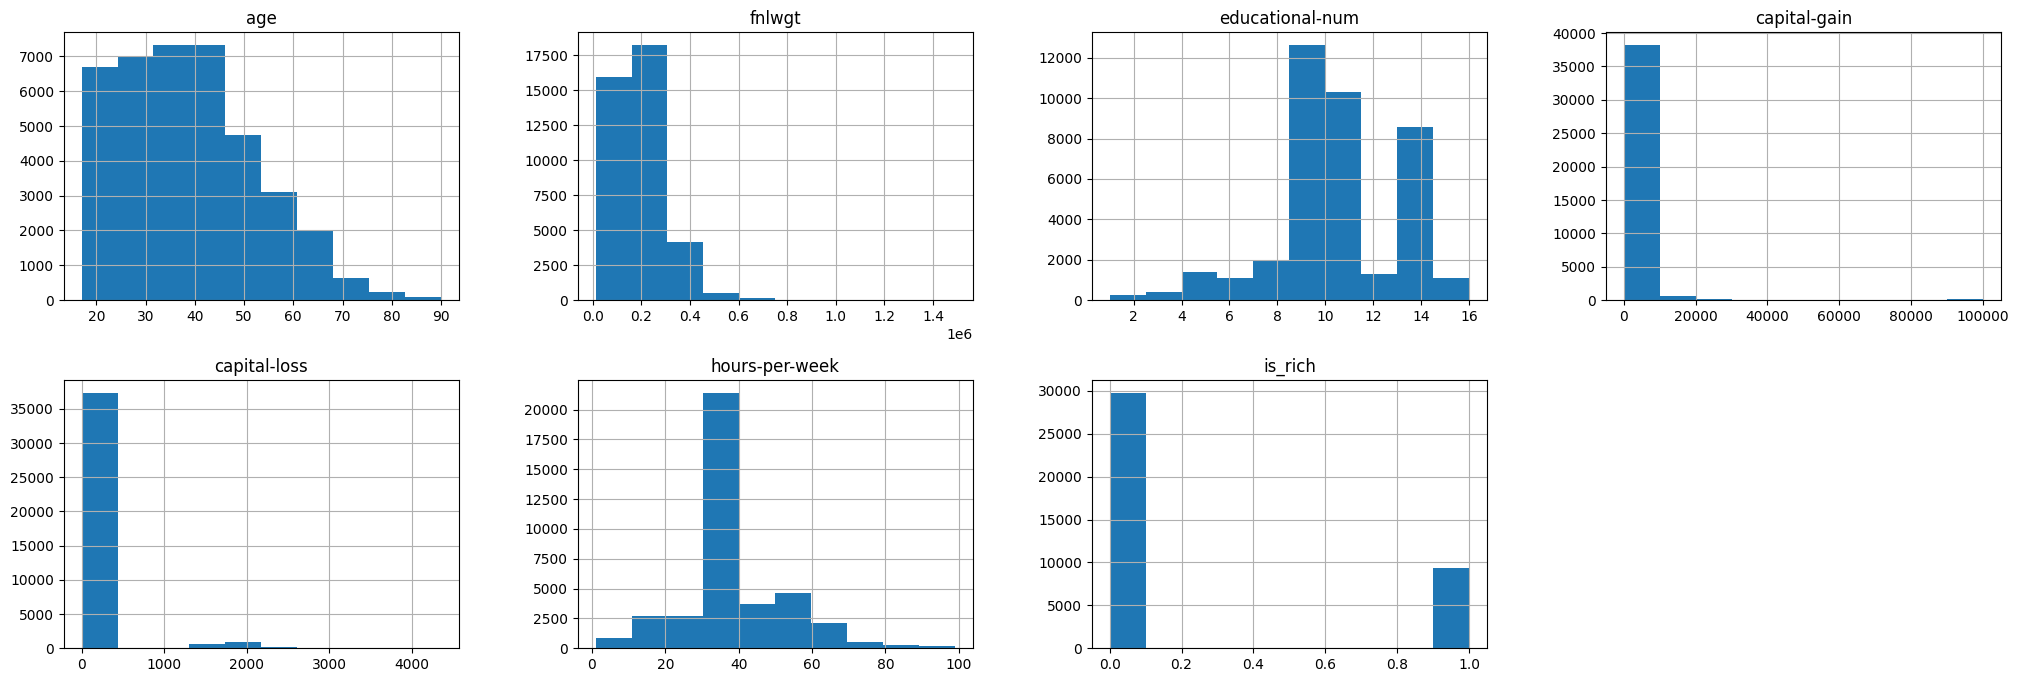

In [3]:
train.drop('id', axis=1).hist(figsize=(25, 8), layout = (-1, 4));

In [4]:
train.is_rich.value_counts()

is_rich
0    29715
1     9359
Name: count, dtype: int64

In [5]:
#checking duplicates
train.duplicated().sum()

0

In [38]:
train.isnull().sum()

id                 0
age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
is_rich            0
dtype: int64

In [39]:
list(train.select_dtypes(['object']).columns)

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'gender',
 'native-country']

In [ ]:
# train['diff_capital'] = train['capital-gain'] - train['capital-loss']
# train['money_week'] = train['diff_capital'] / train['hours-per-week']

In [4]:
#F
train['workclass'] = train['workclass'].mask((train['workclass'] == '?'), 'unknown')
train['occupation'] = train['occupation'].mask((train['occupation'] == '?'), 'unknown')
train['native-country'] = train['native-country'].mask((train['native-country'] == '?'), 'unknown')


In [9]:
# train['gender'] = train['gender'].apply(lambda x: 1 if x== 'Male' else 0)

In [5]:
RANDOM_STATE = 42
results = [] # Здесь будем хранить информацию по каждой модели

In [6]:
def train_model(algorithm,
                X,
                y,
                early_stopping_rounds,
                init_params=None,
                cat_features=None,
                random_seed=2023
    ):
    scores = []
    models = []

    kf = KFold(n_splits=3, shuffle=True, random_state=random_seed)

    print(f"========= TRAINING {algorithm.__name__} =========")

    for num_fold, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if init_params is not None:
            model = algorithm(**init_params)
        else:
            model = algorithm()

        if algorithm.__name__ == 'CatBoostClassifier':
            # Используйте соответствующий класс
            train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)
            eval_dataset = Pool(data=X_test, label=y_test, cat_features=cat_features)

            model.fit(train_dataset,
                      eval_set=eval_dataset,
                      verbose=0,
                      early_stopping_rounds=early_stopping_rounds)

        elif algorithm.__name__ == 'LGBMClassifier':
            # Используйте соответствующий класс
            train_dataset = Dataset(X_train,y_train,categorical_feature=cat_features,free_raw_data=False)
            eval_dataset = Dataset(X_test,y_test,categorical_feature=cat_features,free_raw_data=False)

            model = lgb.train(params=init_params,                              
                              train_set=train_dataset,
                              valid_sets=(eval_dataset),
                              feval=F1_Score_Binary(average='micro'),
                              categorical_feature=cat_features)

        elif algorithm.__name__ == 'XGBClassifier':
            # Используйте соответствующий класс
            train_matrix = xgb.DMatrix(X_train,label=y_train,nthread=-1,enable_categorical=True)
            eval_matrix = xgb.DMatrix(X_test, y_test,nthread=-1,enable_categorical=True)

            model = xgb.train(params=init_params,
                              dtrain=train_matrix,
                              evals=[(train_matrix, 'dtrain'), (eval_matrix, 'dtest')],
                              verbose_eval=False,
                              feval=F1_Score_Binary(average='micro', XGBoost=True),
                              early_stopping_rounds=early_stopping_rounds)
            X_test = eval_matrix

        # Сделайте предсказание на X_eval и посчитайте f1
        y_pred = model.predict(X_test)
        score = f1_score(y_test, y_pred.round(),average='micro')

        models.append(model)
        scores.append(score)

        print(f'FOLD {num_fold}: SCORE {score}')

    mean_kfold_score = np.mean(scores, dtype="float16") -  np.std(scores, dtype="float16")
    print("\nMEAN F1 SCORE", mean_kfold_score)

    # Выберите модель с наименьшим значением скора
    best_model_index = np.argmin(score)
    best_model = models[best_model_index]

    return mean_kfold_score, best_model

In [7]:
def tuning_hyperparams(algorithm,
                       X,
                       y,
                       init_params,
                       fit_params,
                       grid_params,
                       n_iter,
                       cv,
                       random_state=2023,
    ):

    estimator = algorithm(**init_params)

    # Можно использоавть GridSearchCV
    model = RandomizedSearchCV(estimator=estimator,
                               param_distributions=grid_params,
                               n_iter=n_iter,
                               cv=cv,
                               scoring='f1',
                               n_jobs=-1,
                               verbose=0,
                               random_state=random_state
    )

    model.fit(X, y, **fit_params)

    return model.best_params_ | init_params

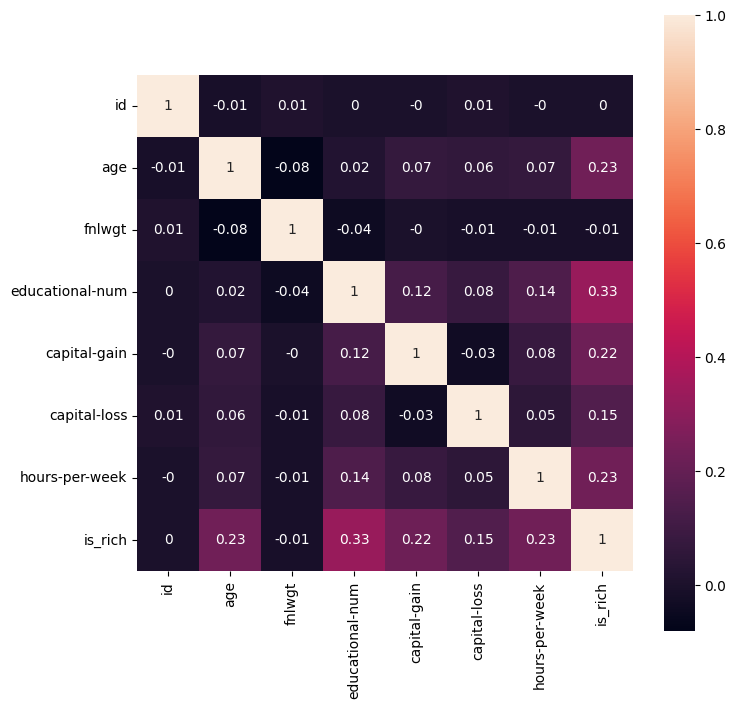

In [8]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(
    data=train.corr(numeric_only=True).round(2),
    square=True,
    annot=True,
);

In [9]:
cat_features = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "gender","native-country"]
targets = ["is_rich"]
features2drop = ["id", "is_rich"]

# Отбираем итоговый набор признаков для использования моделью
filtered_features = [i for i in train.columns if (i not in targets and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]


print("cat_features", cat_features)
print("num_features", num_features)
print("targets", targets)

cat_features ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']
num_features ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
targets ['is_rich']


In [10]:
X = train[filtered_features].drop(targets, axis=1, errors="ignore")
y = train["is_rich"]

# X_train = train[filtered_features].drop(targets, axis=1, errors="ignore")
# y_train = train["is_rich"]

In [11]:
from imblearn.over_sampling import RandomOverSampler

# Создание экземпляра RandomOverSampler
ros = RandomOverSampler()

# Применение увеличения выборки к данным
X_train, y_train = ros.fit_resample(X, y)

In [12]:
cb_init_params = {
    'loss_function': 'Logloss',
    'eval_metric': 'TotalF1:average=Micro',
    'thread_count': -1,
    'random_seed': RANDOM_STATE,
    'task_type': 'GPU',
    'border_count': 254,
    "depth": 7   
}

cb_score, cb_model = train_model(
    algorithm=CatBoostClassifier,
    X=X_train, y=y_train,
    init_params=cb_init_params,
    early_stopping_rounds=50,
    cat_features=cat_features,
    random_seed=RANDOM_STATE
)

========= TRAINING CatBoostClassifier =========
FOLD 0: SCORE 0.8611812216052499
FOLD 1: SCORE 0.8593134780413932
FOLD 2: SCORE 0.8605754669358909

MEAN F1 SCORE 0.86


In [13]:
test = pd.read_csv("/kaggle/input/test-csv/test.csv")
# display(test.head(5))
# test.shape

In [14]:
X_test = test[filtered_features].drop(targets, axis=1, errors="ignore")
pred = cb_model.predict(X_test)

In [15]:
df_submission = pd.DataFrame(data={
    'id':test['id'],
    'Catboost':pred}

)

In [16]:
df_submission

,id,Catboost
0,0,1
1,1,0
2,2,1
3,3,1
4,4,0
...,...,...
9763,9763,1
9764,9764,0
9765,9765,0
9766,9766,0


# LightGBM

In [17]:
X_lgb = X_train.copy()
le = LabelEncoder()
for col in cat_features:
    X_lgb[col] = le.fit_transform(X_lgb[col])

In [18]:
!pip install bokbokbok
from bokbokbok.eval_metrics.classification import F1_Score_Binary

In [19]:
lgb_init_params = {
    'n_jobs': -1,
    'random_state': RANDOM_STATE,
    'verbosity' : -1,
    'device': 'cpu',
    'learning_rate': 0.15,
    'reg_alpha': 0.15
    }


lgb_score, lgb_model = train_model(
    algorithm=LGBMClassifier,
    X=X_lgb, y=y_train,
    init_params=lgb_init_params,
    early_stopping_rounds=50,
    cat_features=cat_features,
    random_seed=RANDOM_STATE,
    
)

========= TRAINING LGBMClassifier =========
[1]	valid_0's l2: 0.214979	valid_0's F1: 0.8211
[2]	valid_0's l2: 0.189505	valid_0's F1: 0.82418
[3]	valid_0's l2: 0.17074	valid_0's F1: 0.826653
[4]	valid_0's l2: 0.156785	valid_0's F1: 0.825644
[5]	valid_0's l2: 0.146195	valid_0's F1: 0.830288
[6]	valid_0's l2: 0.138259	valid_0's F1: 0.830035
[7]	valid_0's l2: 0.13219	valid_0's F1: 0.829934
[8]	valid_0's l2: 0.127555	valid_0's F1: 0.832357
[9]	valid_0's l2: 0.124083	valid_0's F1: 0.834225
[10]	valid_0's l2: 0.121014	valid_0's F1: 0.835134
[11]	valid_0's l2: 0.11869	valid_0's F1: 0.836547
[12]	valid_0's l2: 0.117177	valid_0's F1: 0.83584
[13]	valid_0's l2: 0.11541	valid_0's F1: 0.83786
[14]	valid_0's l2: 0.114398	valid_0's F1: 0.83786
[15]	valid_0's l2: 0.113363	valid_0's F1: 0.839223
[16]	valid_0's l2: 0.112333	valid_0's F1: 0.840485
[17]	valid_0's l2: 0.111737	valid_0's F1: 0.840888
[18]	valid_0's l2: 0.111216	valid_0's F1: 0.841343
[19]	valid_0's l2: 0.110783	valid_0's F1: 0.840787
[20]	v

In [20]:
X_test_lgb = X_test.copy()
le = LabelEncoder()
for col in cat_features:
    X_test_lgb[col] = le.fit_transform(X_test_lgb[col])

In [27]:
df_submission['LGBM'] = lgb_model.predict(X_test_lgb)

In [28]:
df_submission['LGBM'] = df_submission['LGBM'].apply(lambda x: round(x))

In [29]:
df_submission

,id,Catboost,LGBM
0,0,1,1
1,1,0,0
2,2,1,0
3,3,1,1
4,4,0,0
...,...,...,...
9763,9763,1,1
9764,9764,0,0
9765,9765,0,0
9766,9766,0,0


# XGBoost

In [30]:
X_xgb = X_train.copy()
for col in cat_features:
    X_xgb[col] = X_xgb[col].astype('category')

In [31]:
xgb_init_params = {
    'objective': 'binary:logistic',
    'learning_rate': 0.28,
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
    'reg_alpha' : 0.15,
    'verbosity': 0,
#     'enable_categorical' : True
   }


xgb_score, xgb_model = train_model(
    algorithm=XGBClassifier,
    X=X_xgb, y=y_train,
    init_params=xgb_init_params,
    early_stopping_rounds=50,
    cat_features=cat_features,
    random_seed=RANDOM_STATE
)

========= TRAINING XGBClassifier =========
FOLD 0: SCORE 0.837809187279152
FOLD 1: SCORE 0.8392226148409894
FOLD 2: SCORE 0.8378596668349318

MEAN F1 SCORE 0.838


In [32]:
X_test_xgb = X_test.copy()
for col in cat_features:
    X_test_xgb[col] = X_test_xgb[col].astype('category')
test_xgb = xgb.DMatrix(X_test_xgb, nthread=-1, enable_categorical=True)

In [33]:
df_submission['XGBoost'] = xgb_model.predict(test_xgb,  iteration_range=(0, xgb_model.best_iteration + 1))

In [35]:
df_submission['XGBoost'] = df_submission['XGBoost'].apply(lambda x: round(x))

In [36]:
df_submission

,id,Catboost,LGBM,XGBoost
0,0,1,1,1
1,1,0,0,0
2,2,1,0,1
3,3,1,1,1
4,4,0,0,0
...,...,...,...,...
9763,9763,1,1,1
9764,9764,0,0,0
9765,9765,0,0,1
9766,9766,0,0,0


## another models

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV, RandomizedSearchCV

In [38]:
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_lgb, y_train, test_size=0.2)

In [39]:
lg = LogisticRegression(random_state=42, max_iter=1000)
lg.fit(X_train_n, y_train_n) # LogisticRegression

LogisticRegression(max_iter=1000, random_state=42)

In [49]:
pred_lg = lg.predict(X_test_n)
f1_score(y_test_n, pred_lg,average='micro')

0.6620393740535083

In [50]:
cross_validate(lg, X_lgb, y_train, scoring='f1_micro', cv=3)

{'fit_time': array([0.94351387, 0.14785337, 0.55887365]),
 'score_time': array([0.02078962, 0.01875973, 0.0211153 ]),
 'test_score': array([0.6953054 , 0.61564866, 0.65795053])}

In [51]:
df_submission['LogisticRegression'] = lg.predict(X_test_lgb)

In [52]:
df_submission

,id,Catboost,LGBM,XGBoost,LogisticRegression
0,0,1,1,1,1
1,1,0,0,0,0
2,2,1,0,1,1
3,3,1,1,1,0
4,4,0,0,0,0
...,...,...,...,...,...
9763,9763,1,1,1,1
9764,9764,0,0,0,0
9765,9765,0,0,1,1
9766,9766,0,0,0,0


### --

In [53]:
mlp = MLPClassifier(random_state=42, max_iter=1000)
mlp.fit(X_train_n, y_train_n)

MLPClassifier(max_iter=1000, random_state=42)

In [105]:
pred_mlp = mlp.predict(X_test_n)
f1_score(y_test_n, pred_mlp,average='micro')

0.5495540972572774

In [54]:
cross_validate(mlp, X_lgb, y_train, scoring='f1_micro', cv=3)

{'fit_time': array([17.57117128, 17.69103336, 20.84104156]),
 'score_time': array([0.03408742, 0.0325613 , 0.05417418]),
 'test_score': array([0.55396265, 0.62044422, 0.57516406])}

In [55]:
df_submission['MLPClassifier'] = mlp.predict(X_test_lgb)

In [56]:
df_submission

,id,Catboost,LGBM,XGBoost,LogisticRegression,MLPClassifier
0,0,1,1,1,1,1
1,1,0,0,0,0,0
2,2,1,0,1,1,1
3,3,1,1,1,0,0
4,4,0,0,0,0,0
...,...,...,...,...,...,...
9763,9763,1,1,1,1,0
9764,9764,0,0,0,0,0
9765,9765,0,0,1,1,0
9766,9766,0,0,0,0,0


In [57]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_n, y_train_n)

RandomForestClassifier(random_state=42)

In [58]:
pred_rf = rf.predict(X_test_n)
f1_score(y_test_n, pred_rf,average='micro')

0.9316002019182231

In [59]:
cross_validate(rf, X_lgb, y_train, scoring='f1_micro', cv=3)

{'fit_time': array([4.44700742, 4.38143063, 4.5175457 ]),
 'score_time': array([0.4003365 , 0.41662741, 0.39691758]),
 'test_score': array([0.92498738, 0.93336699, 0.93760727])}

In [60]:
df_submission['RandomForestClassifier'] = rf.predict(X_test_lgb)

In [65]:
df_submission

,id,Catboost,LGBM,XGBoost,LogisticRegression,MLPClassifier,RandomForestClassifier
0,0,1,1,1,1,1,1
1,1,0,0,0,0,0,0
2,2,1,0,1,1,1,0
3,3,1,1,1,0,0,1
4,4,0,0,0,0,0,0
...,...,...,...,...,...,...,...
9763,9763,1,1,1,1,0,1
9764,9764,0,0,0,0,0,0
9765,9765,0,0,1,1,0,0
9766,9766,0,0,0,0,0,0


In [67]:
df_submission['final_prediction'] = df_submission.mode(axis=1)[0]

In [69]:
df_submission['final_prediction']= df_submission['final_prediction'].apply(lambda x: round(x))

In [71]:
df_submission

,id,Catboost,LGBM,XGBoost,LogisticRegression,MLPClassifier,RandomForestClassifier,final_prediction
0,0,1,1,1,1,1,1,1
1,1,0,0,0,0,0,0,0
2,2,1,0,1,1,1,0,1
3,3,1,1,1,0,0,1,1
4,4,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
9763,9763,1,1,1,1,0,1,1
9764,9764,0,0,0,0,0,0,0
9765,9765,0,0,1,1,0,0,0
9766,9766,0,0,0,0,0,0,0


In [73]:
pd.DataFrame({'Id': test['id'], 'is_reach': df_submission['final_prediction']}).to_csv('final_submission.csv', index=False)

In [74]:
pd.DataFrame({'Id': test['id'], 'is_reach': df_submission['RandomForestClassifier']}).to_csv('RandomForestClassifier.csv', index=False)